In [91]:
import pandas as pd

In [92]:
data = []

duration = "duration(ns/round)"
template_dict = {
    "world size":0,
    "thread number":0,
    "problem size":0,
    "speed(px/s)":0.0,
    "duration(ns/round)":0.0,
    "rounds":1,
}
filename=input("filename=")

In [93]:
if filename.startswith("mpi"):
    world_size = "world size"
elif filename.startswith("hybrid"):
    world_size = "thread number"
else:
    world_size = "thread number"
with open(f"../logs/{filename}.log","r") as f:
    for line in f.readlines():
        if line.find(":") == -1:
            continue
        try:
            key,val = line.rstrip().split(":")
        except ValueError:
            display(line,key,val)
        val = val[1:]
        if key == world_size:
            data.append({})
        data[-1][key] = val
df = pd.DataFrame(data,dtype=float)
display(df[df.isna().any(axis=1)])
# df = df.dropna(axis=1)
df = df.convert_dtypes()
display(df.dtypes)
display(df.head())

,world size,problem size,duration(ns/round),rounds


world size            Int64
problem size          Int64
duration(ns/round)    Int64
rounds                Int64
dtype: object

,world size,problem size,duration(ns/round),rounds
0,1,200,379560,10
1,1,1000,9437925,10
2,1,5000,235465862,10
3,1,10000,943708047,10
4,2,200,235336,10


In [94]:
def get_one_core_duration(row,t1_df):
    t1 = t1_df.loc[t1_df["problem size"]==row["problem size"]][duration].values[0]
    return t1/row[duration]
t1_df = df[df[world_size]==1]
display(t1_df)
df["speedup"] = df.apply(get_one_core_duration,args=(t1_df,),axis=1)
display(df.head())

,world size,problem size,duration(ns/round),rounds
0,1,200,379560,10
1,1,1000,9437925,10
2,1,5000,235465862,10
3,1,10000,943708047,10


,world size,problem size,duration(ns/round),rounds,speedup
0,1,200,379560,10,1.000000
1,1,1000,9437925,10,1.000000
2,1,5000,235465862,10,1.000000
3,1,10000,943708047,10,1.000000
4,2,200,235336,10,1.612843


In [95]:
tmp_df = df
df=df[df[world_size]<=32]
tmp_df = df[df[world_size].isin(range(1,32,3))]
tmp_df.set_index('problem size', inplace=True)

world size
1     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
19    AxesSubplot(0.125,0.125;0.775x0.755)
22    AxesSubplot(0.125,0.125;0.775x0.755)
25    AxesSubplot(0.125,0.125;0.775x0.755)
28    AxesSubplot(0.125,0.125;0.775x0.755)
31    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration(ns/round), dtype: object

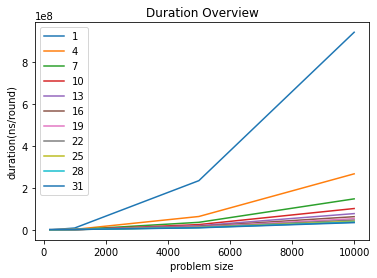

In [96]:
tmp_df.groupby(world_size)[duration].plot(legend=True,title="Duration Overview",ylabel=duration)

world size
1     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
19    AxesSubplot(0.125,0.125;0.775x0.755)
22    AxesSubplot(0.125,0.125;0.775x0.755)
25    AxesSubplot(0.125,0.125;0.775x0.755)
28    AxesSubplot(0.125,0.125;0.775x0.755)
31    AxesSubplot(0.125,0.125;0.775x0.755)
Name: speedup, dtype: object

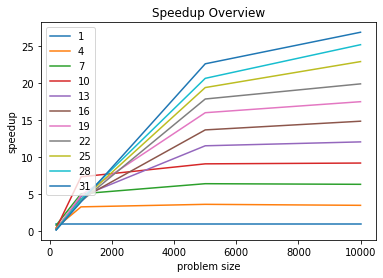

In [97]:
tmp_df.groupby(world_size)["speedup"].plot(legend=True,title="Speedup Overview",ylabel="speedup")

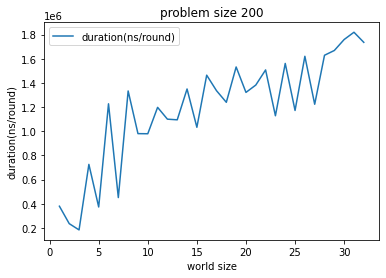

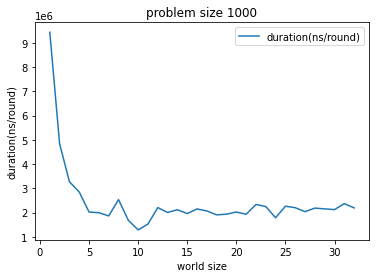

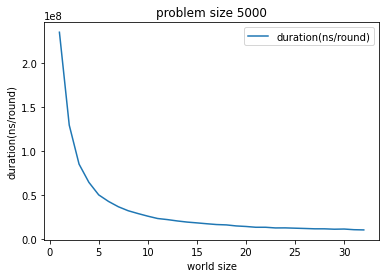

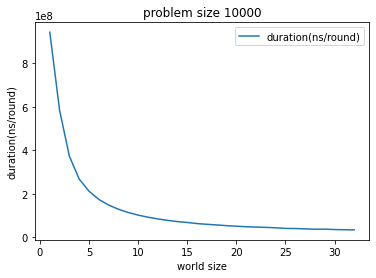

In [98]:
for input_size, group in df.groupby("problem size"):
    group.plot(x=world_size,y=duration,title=f"problem size {int(input_size)}",ylabel=duration)

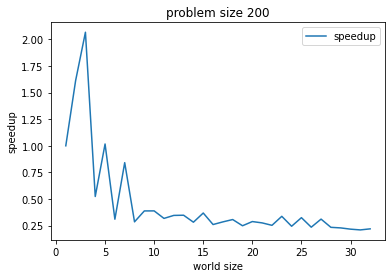

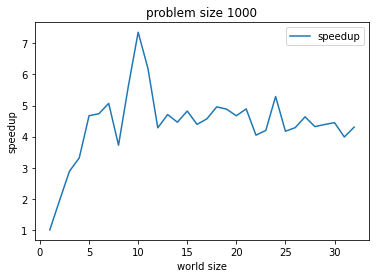

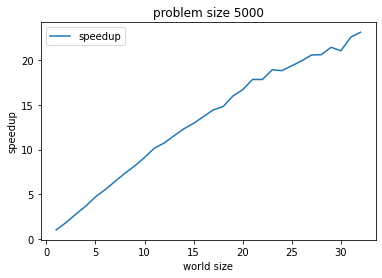

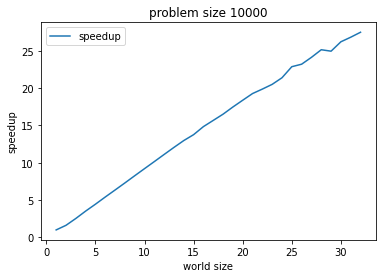

In [99]:
for input_size, group in df.groupby("problem size"):
    group.plot(x=world_size,y="speedup",title=f"problem size {input_size}",ylabel="speedup")

In [102]:
print(df.loc[lambda x:x["problem size"]==200].to_string())

     world size  problem size  duration(ns/round)  rounds   speedup
0             1           200              379560      10  1.000000
4             2           200              235336      10  1.612843
8             3           200              183530      10  2.068109
12            4           200              725631      10  0.523076
16            5           200              373269      10  1.016854
20            6           200             1226832      10  0.309382
24            7           200              451104      10  0.841402
28            8           200             1332907      10  0.284761
32            9           200              980017      10  0.387299
36           10           200              979034      10  0.387688
40           11           200             1197419      10  0.316982
44           12           200             1099681      10  0.345155
48           13           200             1094265      10  0.346863
52           14           200             134933

In [101]:
# df.loc[lambda x:x[world_size] == 33].to_string()
